# Homework 5: Dimensionality Reduction and Clustering

For this homework, I will use the Modified National Institute of Standards and Technology (MNIST) data set to practice dimensionality reduction and clustering. MNIST is a data set containing thousands of handwritten numbers. Each row represents an image of a digit (0-9) that measures 28 by 28 pixels, giving it 784 features in total. Each pixel is represented by a discrete number that indicates its brightness, with 0 signifying the lightest shade and 255 being the darkest.  

The goal of this exercise is to experiment with PCA, t-SNE, k-Means Clustering and Hierarchical Clustering to see: (1) how I can decrease the number of features, and (2) if my clustering methods will learn to recognize the disctinctions between each digit.

In [3]:
#import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [4]:
#read in the data
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

In [3]:
X.shape

(70000, 784)

This means we have 784 features for 70,000 observations. As discussed in class, using less than 784 features will cut down on runtime while still preserving a lot of variation in the data.

In [4]:
y.shape

(70000,)

This vector has a label (0-9) for each digit in our data.

## 1. Use Principal Component Analysis (PCA) to reduce the dimensionality

The main question with PCA is, "How many components should we use?" I'll look at this in two ways: first, using the elbow method, and second, by setting a benchmark of how much of the variance I'd like explained.

In [5]:
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA

To use the elbow method, I'll just need to plot the percentage of variance explained by each number of components. When the curve starts to level off (at the elbow), we can see that adding more components won't be as useful anymore.

Text(0,0.5,'Explained Variance Ratio')

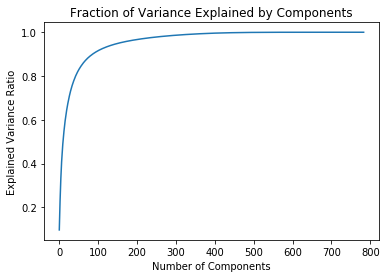

In [6]:
#code from Lecture 12 for using the elbow method
pca = PCA(n_components=784) #784 is the number of features, so we can use any amount of components that's less than that
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)

plt.title("Fraction of Variance Explained by Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")

It looks like the elbow happens at around 75 components. I'll draw a line up to that point to make sure.

Text(0,0.5,'Explained Variance Ratio')

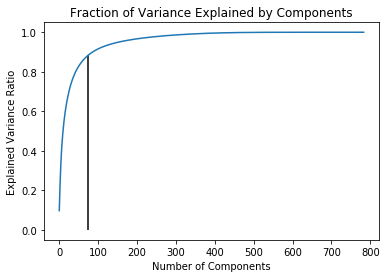

In [7]:
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[75],x=75)

plt.title("Fraction of Variance Explained by Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")

We've definitely hit the elbow here, but it just explains about 90% of the variance. I'll try the other method to see how many components it would take to explain 95% of the variance.

In [9]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(70000, 154)


This means we'll need 154 components to describe 95% of the data set's variation.

### a. How many components did you use? Why? 

At first, I used 154 components because I thought it was more important to keep the compressed data "true" to how it was originally. However, this meant I had twice the components for only about 5% more variance explained. That didn't seem worth it to me, so to decrease runtime, I went back to using just 75 components.

In [6]:
pca = PCA(n_components=75) 
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(70000, 75)


### b. Plot the first two components. Do you notice any trends? What is this plot showing us? 

Text(0,0.5,'Component 2')

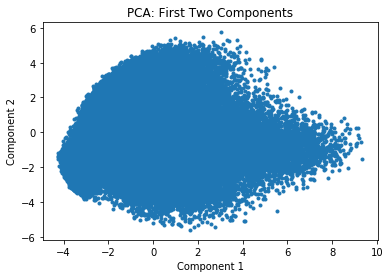

In [10]:
plt.scatter(X_pca[:,0], X_pca[:,1], marker=".")
plt.title("PCA: First Two Components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

No, there are no noticeable trends here; the data seem to be quasi-randomly scattered throughout the plot. It makes sense that the first two components would appear uncorrelated because they are orthogonal to each other and are each trying to pick up different variations in the data set.

### c. Why would you use PCA? What is it doing? And what are the drawbacks?

We use PCA to combat the curse of dimensionality; data in high dimensions tends to be very sparse, making it difficult to find trends or clusters. PCA projects our data onto lines that preserve the most variance in the data, allowing us to decrease dimensionality without explicitly dropping features that could be important in analysis. Drawbacks of this approach include losing some information (variation in the data) and relying on an assumption of linear relationships between variables.

### d. Plot some of the images, then compress them using PCA and plot again. How does it look?

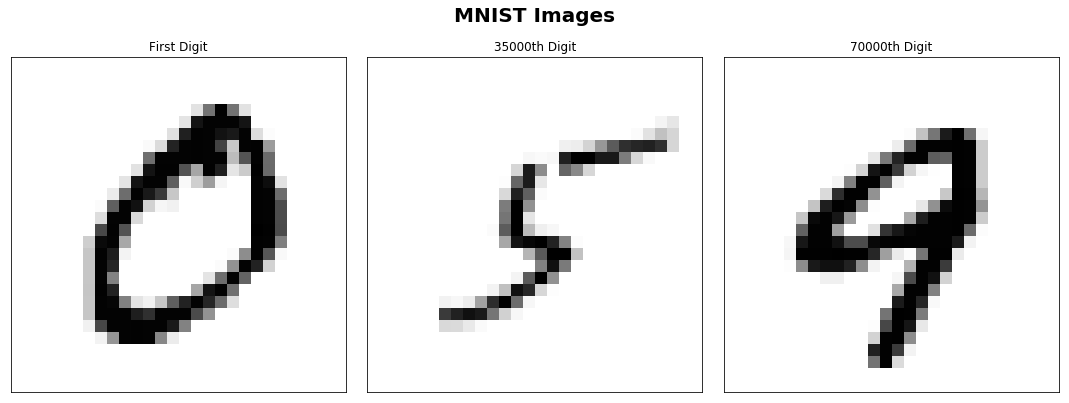

In [11]:
plt.figure(figsize=(15,5))
plt.suptitle("MNIST Images", fontsize = 20, fontweight = "bold", y = 1.1)
plt.subplot(1,3,1)
plt.title("First Digit")
plt.xticks([])
plt.yticks([])
plt.imshow(X[0].reshape((28,28)), cmap='Greys')
plt.subplot(1,3,2)
plt.title("35000th Digit")
plt.xticks([])
plt.yticks([])
plt.imshow(X[35000].reshape((28,28)), cmap='Greys')
plt.subplot(1,3,3)
plt.title("70000th Digit")
plt.xticks([])
plt.yticks([])
plt.imshow(X[69999].reshape((28,28)), cmap='Greys')
plt.tight_layout()

In [12]:
#decompress the data
X_decomp = pca.inverse_transform(X_pca)

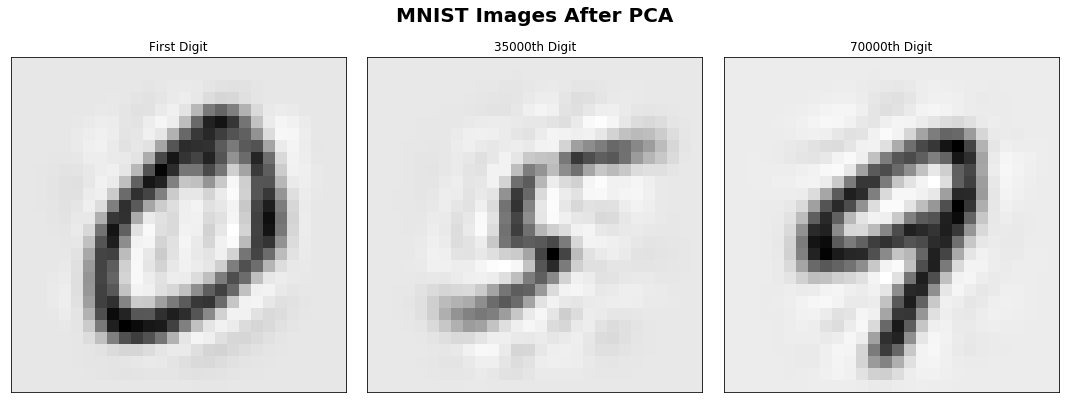

In [13]:
plt.figure(figsize=(15,5))
plt.suptitle("MNIST Images After PCA", fontsize = 20, fontweight = "bold", y = 1.1)
plt.subplot(1,3,1)
plt.title("First Digit")
plt.xticks([])
plt.yticks([])
plt.imshow(X_decomp[0].reshape((28,28)), cmap='Greys')
plt.subplot(1,3,2)
plt.title("35000th Digit")
plt.xticks([])
plt.yticks([])
plt.imshow(X_decomp[35000].reshape((28,28)), cmap='Greys')
plt.subplot(1,3,3)
plt.title("70000th Digit")
plt.xticks([])
plt.yticks([])
plt.imshow(X_decomp[69999].reshape((28,28)), cmap='Greys')
plt.tight_layout()

The images look roughly the same as they did before, but blurrier, showing that PCA caused us to lose some variation in the data.

## 2. Use t-SNE to plot the first two components

In [7]:
from sklearn.manifold import TSNE

In [8]:
#randomly sample 10000 of our rows at a time (code from Lecture 12)
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

In [16]:
#define a function that will use t-SNE to create a graph for any perplexity, number of iterations, and learning rate
def TSNE_graph(perplexity_level, num_iterations, learning_rate_choice):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity_level, n_iter=num_iterations, learning_rate=learning_rate_choice)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
    ax = plt.gca()
    ax.set_title("T-SNE with Perplexity = " + str(perplexity_level) + ", LR = " + str(learning_rate_choice) + ", and " + str(num_iterations) + " Iterations")
    ax.set(xlabel='Component 1', ylabel='Component 2')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.036s...
[t-SNE] Computed neighbors for 10000 samples in 27.609s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.051125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.993896
[t-SNE] Error after 1000 iterations: 1.700304


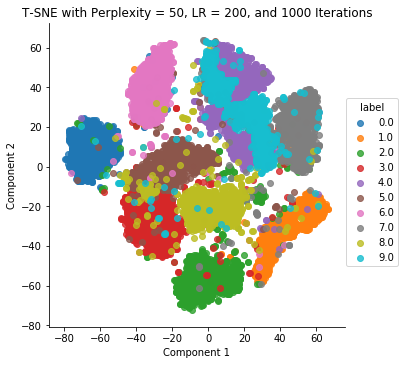

In [17]:
#do t-SNE with a perplexity value of 50, run 1000 times with a learning rate of 200
TSNE_graph(50, 1000, 200)

### a. How does this plot differ from your PCA plot?

This plot is much easier to interpret; instead of just being a random cloud of points, the first two t-SNE components do a good job of visualizing clusters in our data.

### b. How robust is it to changes in perplexity?

According to the t-SNE article referenced in lecture (https://distill.pub/2016/misread-tsne/), reasonable values for perplexity range from 5 to 50. I'll try perplexity values of 5 and 25 in addition to the 50 I used for the original plot.

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.039s...
[t-SNE] Computed neighbors for 10000 samples in 22.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.803939
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.042160
[t-SNE] Error after 1000 iterations: 1.834470


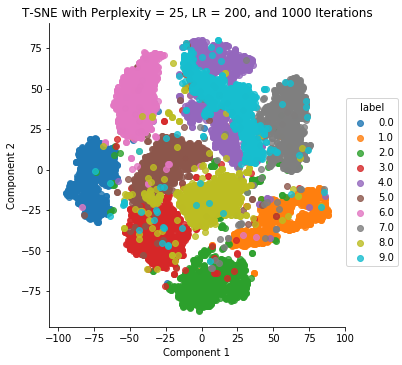

In [18]:
TSNE_graph(25, 1000, 200)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.043s...
[t-SNE] Computed neighbors for 10000 samples in 21.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.205145
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.625122
[t-SNE] Error after 1000 iterations: 1.946616


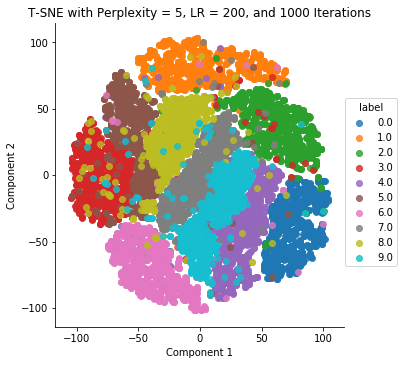

In [19]:
TSNE_graph(5, 1000, 200)

Clusters in the data are a little less distinct with a perplexity of 25 and quite a bit less distinct with a perplexity of 5. Interestingly, the graph with perplexity 5 seems to have less overlap between images of 4 and 9, but its "1" cluster has been split in two.

### c. How robust is it to a different learning rate and number of iterations?

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.040s...
[t-SNE] Computed neighbors for 10000 samples in 25.502s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.051125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.990273
[t-SNE] Error after 1000 iterations: 1.733065


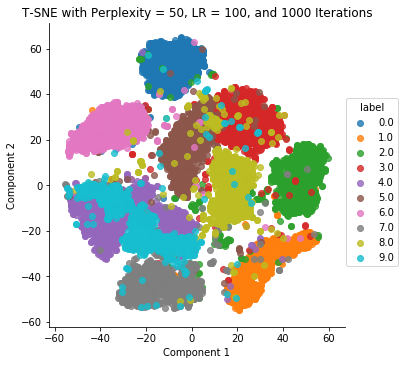

In [20]:
#learning rate = 100
TSNE_graph(50, 1000, 100)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.040s...
[t-SNE] Computed neighbors for 10000 samples in 26.835s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.051125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.988503
[t-SNE] Error after 1000 iterations: 1.684654


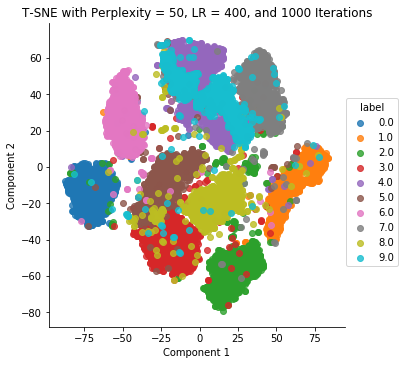

In [21]:
TSNE_graph(50, 1000, 400)

The results look pretty robust to different learning rates. The clusters appear about the same whether the learning rate is 100, 200, or 400.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.034s...
[t-SNE] Computed neighbors for 10000 samples in 24.892s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.051125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.004898
[t-SNE] Error after 251 iterations: 17976931348623157081452742373170435679807

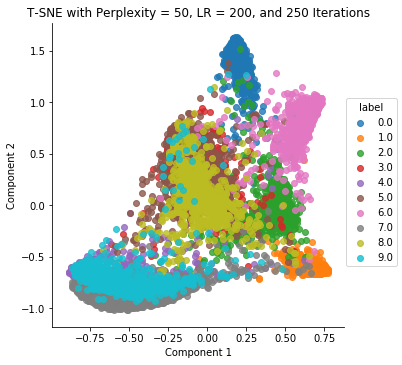

In [22]:
TSNE_graph(50, 250, 200) 

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.047s...
[t-SNE] Computed neighbors for 10000 samples in 24.983s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.051125
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.971008
[t-SNE] Error after 1500 iterations: 1.687254


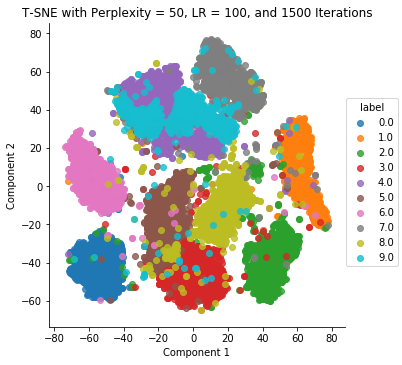

In [23]:
TSNE_graph(50, 1500, 100)

The numbers 2, 3, 5, and 8 did not form distinct clusters after only 250 iterations. It seems to have stabilized after 1000 iterations, though, because my original graph with 1000 iterations does not look very different from the graph above, which used 1500.

## 3. Perform k-means clustering

In [9]:
from sklearn.cluster import KMeans

In [10]:
#k-means using full raw data
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
sk_clusters = kmeans.predict(X[rows[:n_select],:])

### a. How did you choose k?

I chose a k of 10 classes because we're trying to predict whether a given image shows a digit 0-9. 

### b. How did you evaluate your clustering?

I used Adjusted Rand Index to evaluate my clustering. It uses a function to compare the true labels to our predicted ones and returns a metric of the two vectors' similarity. Bad labeling returns a score that's negative or close to 0, while perfect labeling returns a score of 1.

In [11]:
from sklearn import metrics

In [13]:
pred_labels = kmeans.labels_
metrics.adjusted_rand_score(y, pred_labels)  

0.36667709159369255

A score of 0.37 doesn't seem terrible, but there's definitely room for improvement here. I'll try some other ways of k-means clustering in part (e).

### c. Visualize your clusters using t-SNE

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.048s...
[t-SNE] Computed neighbors for 10000 samples in 25.695s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.041911
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.369514
[t-SNE] Error after 1000 iterations: 1.692209


[Text(32.02,0.5,'Component 2'), Text(0.5,20.8,'Component 1')]

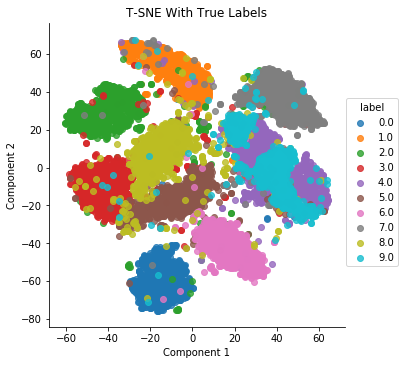

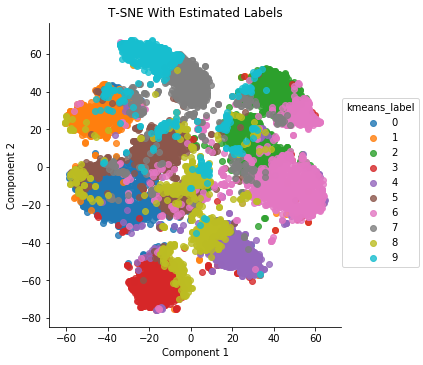

In [18]:
#t-SNE with true labels
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['label'] = y[rows[:n_select]]
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
ax = plt.gca()
ax.set_title("T-SNE With True Labels")
ax.set(xlabel='Component 1', ylabel='Component 2')

#t-SNE with estimated k-means labels
df_tsne['kmeans_label'] = sk_clusters
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='kmeans_label', fit_reg=False)
ax = plt.gca()
ax.set_title("T-SNE With Estimated Labels")
ax.set(xlabel='Component 1', ylabel='Component 2')

The classes that k-Means clustering predicted look fairly similar to the data set's actual classes. The estimates do have more noise, however. The biggest differences seem to occur in the top and bottom middle, where the clusters that are actually 1's and 6's get split in two in the estimates.

### d. Did you scale your data?

Because all of the data points are on the same scale (0-255), I chose not to scale the data.

### e. How robust is your clustering?

I'll check the robustness of my clustering in two different ways: first, using a random sample of 10,000 observations in the original data set, and then doing the same for the PCA-compressed data set.

In [14]:
#k-means using subsample of raw data
kmeans_sample = KMeans(n_clusters=10)
kmeans_sample.fit(X[rows[:n_select],:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
pred_labels_sample = kmeans_sample.labels_
metrics.adjusted_rand_score(y[rows[:n_select]], pred_labels_sample)  

0.38020244605330855

In [18]:
#k-means using subsample of compressed data
kmeans_pca = KMeans(n_clusters=10)
kmeans_pca.fit(X_pca[rows[:n_select],:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
pred_labels_pca = kmeans_pca.labels_
metrics.adjusted_rand_score(y[rows[:n_select]], pred_labels_pca)  

0.36629879739933641

Neither model performed much better than my original one, although using k-Means on a random sample of 10,000 data points seems to be a little better than using the entire data set. 

## 4. Perform hierarchical clustering

### a. Plot your dendrogram

First, I'll plot a dendrogram using the "complete" linkage method, which measures proximity between clusters using the distance between two clusters' farthest neighbors.

In [21]:
#allow for a random sample of 100 observations from the MNIST data
rows = np.arange(70000)
np.random.shuffle(rows)
n_select_100 = 100

Text(0.5,1,'Complete Linkage Dendrogram')

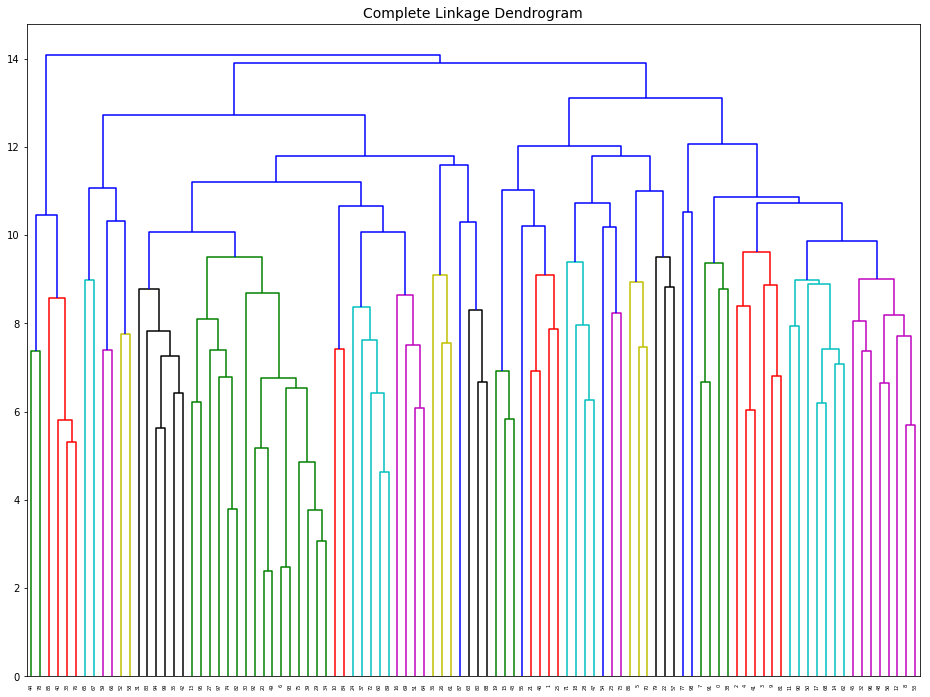

In [27]:
#dendrogram code from lecture
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X[rows[:n_select_100],:], 'complete')
plt.figure(figsize=(16, 12))
dendro_complete = dendrogram(Z)
plt.title("Complete Linkage Dendrogram", fontsize=14)

### b. How many clusters seem reasonable based off your graph?

Looking at the graph, it seems like we should use 7-15 clusters because it takes a while for the clusters to converge after that point. This is good because we're trying to predict 10 classes, which falls in the middle of that range! 

### c. How does your dendrogram change with different linkage methods?

Next, I'll try the single linkage (also called nearest neighbor) method. This algorithm uses distance between two clusters' nearest data points when merging.

Text(0.5,1,'Single Linkage Dendrogram')

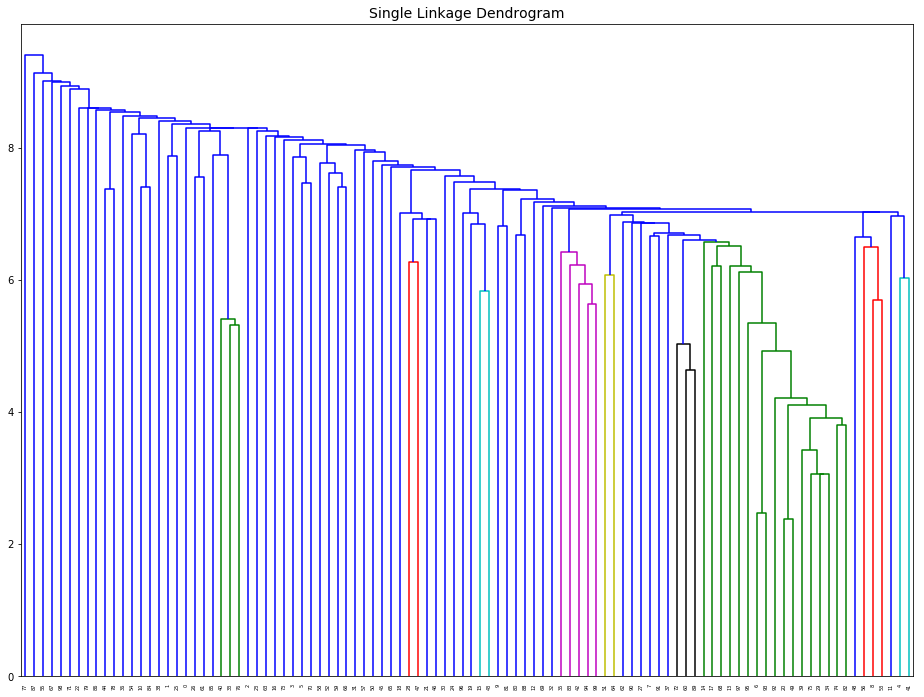

In [25]:
#Single linkage method
Y = linkage(X[rows[:n_select_100],:], 'single')
plt.figure(figsize=(16, 12))
dendro_single = dendrogram(Y)
plt.title("Single Linkage Dendrogram", fontsize=14)

This dendrogram doesn't show much clustering until the very end of the process. It would be difficult to decide on clusters using only this graph.

Finally, I'll use the ward linkage method, which minimizes the total within-cluster variance after merging. 

Text(0.5,1,'Ward Linkage Dendrogram')

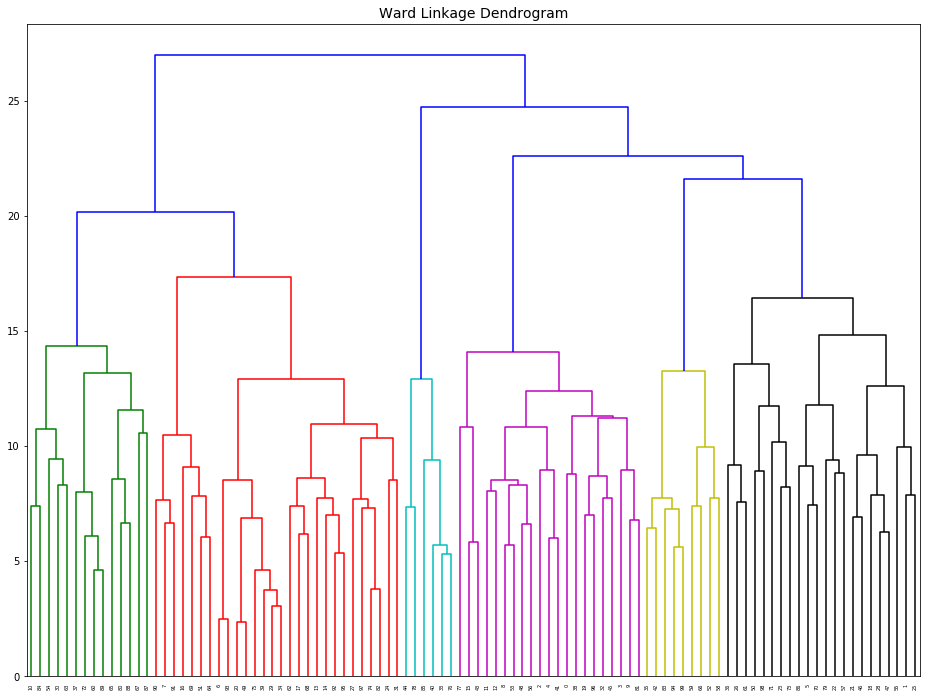

In [28]:
#Ward linkage method
W = linkage(X[rows[:n_select_100],:], 'ward')
plt.figure(figsize=(16, 12))
dendro_ward = dendrogram(W)
plt.title("Ward Linkage Dendrogram", fontsize=14)

Compared with the other two, this dendrogram has easily identifiable clusters-- but there are only six of them (if you count each color as its own cluster). Luckily, moving a little further down the dendrogram still yields 9-10 distinct clusters.

Overall, my clustering methods for the MNIST data set seem to perform fairly well, but there's still room for improvement in their predictions. Next time, I would try clustering with more iterations and compare scores across more subsets of the data.